# Burnout en empleados corporativos
## Aprendizaje de Máquina - TP FINAL

---
## Desarrollo del modelo Support Vector Machine (SVM)
---

#### Carga de datos

In [101]:
#importar librerias
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np


In [115]:
# Cargar de los datasets
X_train = pd.read_csv("output/burnout_X_train.csv")
y_train = pd.read_csv("output/burnout_y_train.csv")
X_test = pd.read_csv("output/burnout_X_test.csv")
y_test = pd.read_csv("output/burnout_y_test.csv")
X_train_PCA = pd.read_csv("output/burnout_X_train_PCA.csv").values
X_test_PCA = pd.read_csv("output/burnout_X_test_PCA.csv").values

In [103]:
#check unique values in y_train
print(y_train['BurnRate_Class'].unique())

[1. 0. 2.]


In [104]:
#Escalado de features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# scaler_PCA = StandardScaler()
# X_train_PCA_scaled = scaler_PCA.fit_transform(X_train_PCA)
# X_test_PCA_scaled = scaler_PCA.transform(X_test_PCA)

In [105]:
# Mapeo de clases a etiquetas para mejor representación
class_mapping = {
    0.0: 'Bajo',
    1.0: 'Medio',
    2.0: 'Alto'
}

### A continuación se tomará el tiempo de 3 ejecuciones de los entrenamientos, para comparar si hay alguna ventaja entre PCA y el dataset completo.

In [106]:
%%timeit -n 3
svm_model = OneVsRestClassifier(
    SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
)
svm_model.fit(X_train_scaled, y_train['BurnRate_Class'])

18.8 s ± 128 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [107]:

# Predecir probabilidades en el set de test
y_score = svm_model.predict_proba(X_test_scaled)

# Binarizar las etiquetas reales para ROC multiclase
# Creacion de una lista ordenada de clases
class_names = [class_mapping[c] for c in sorted(class_mapping.keys())]
classes = np.sort(y_train['BurnRate_Class'].unique())  # e.g., [0, 1, 2]
y_test_bin = label_binarize(y_test['BurnRate_Class'], classes=classes)


#### Se repite ahora para PCA

In [116]:
%%timeit -n 3
svm_model_PCA = OneVsRestClassifier(
    SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
)
svm_model_PCA.fit(X_train_PCA, y_train['BurnRate_Class'])

18.4 s ± 62 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [135]:
# Predecir probabilidades en el set de test
y_score_PCA = svm_model_PCA.predict_proba(X_test_PCA)
#y_score_PCA = svm_model_PCA.predict_proba(X_test_PCA_scaled)


# Binarizar las etiquetas reales para ROC multiclase
classes_PCA = np.sort(y_train['BurnRate_Class'].unique())  # e.g., [0, 1, 2]
y_test_bin_PCA = label_binarize(y_test['BurnRate_Class'], classes=classes_PCA)


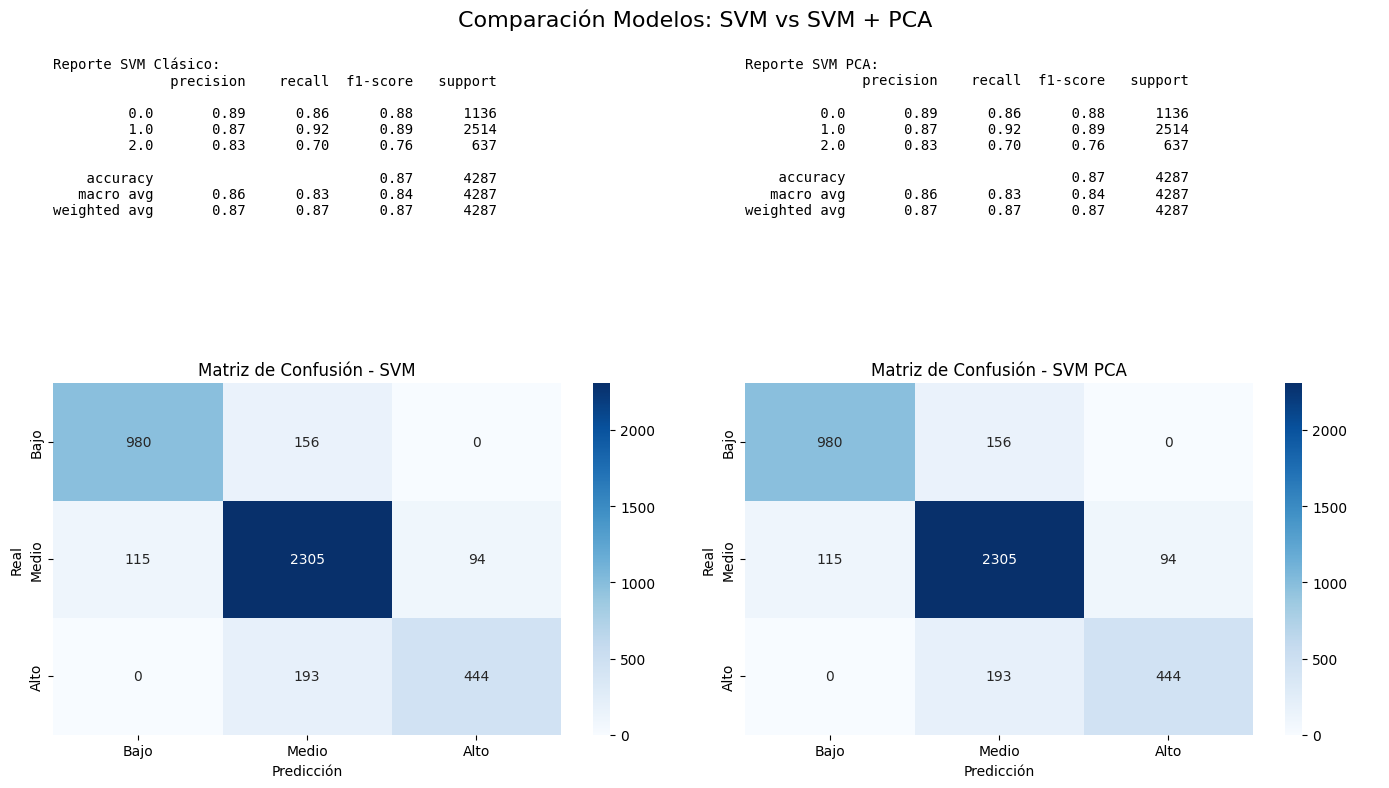

In [136]:
# Cálculos de las matrices de confusión y reportes.
# Se generan en modo de poder ver el resultado lado a lado para poder comparar mejor los resultados

# Generar classification reports como string
report_plain = classification_report(y_test, y_pred)
report_pca = classification_report(y_test, y_pred_PCA)

# Calcular matrices de confusión
cm_plain = confusion_matrix(y_test, y_pred)
cm_pca = confusion_matrix(y_test, y_pred_PCA)

# Crear figura y ajustar el espacio
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])  # Ajusta alto relativo entre texto y matriz

# Reporte SVM Clásico
ax1 = fig.add_subplot(gs[0, 0])
ax1.axis('off')
ax1.text(0, 1, "Reporte SVM Clásico:\n" + report_plain, fontsize=10, family='monospace', va='top')

# Reporte SVM PCA
ax2 = fig.add_subplot(gs[0, 1])
ax2.axis('off')
ax2.text(0, 1, "Reporte SVM PCA:\n" + report_pca, fontsize=10, family='monospace', va='top')

# Matriz SVM Clásico
ax3 = fig.add_subplot(gs[1, 0])
sns.heatmap(cm_plain, annot=True, fmt='d', cmap='Blues',  ax=ax3, xticklabels=class_names, yticklabels=class_names)
ax3.set_title('Matriz de Confusión - SVM')
ax3.set_xlabel("Predicción")
ax3.set_ylabel("Real")

# Matriz SVM PCA
ax4 = fig.add_subplot(gs[1, 1])
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Blues', ax=ax4, xticklabels=class_names, yticklabels=class_names)
ax4.set_title('Matriz de Confusión - SVM PCA')
ax4.set_xlabel("Predicción")
ax4.set_ylabel("Real")

# Ajustar el layout
plt.tight_layout(h_pad=1.0, w_pad=2.0)  # Reducí h_pad si querés menos espacio vertical
plt.subplots_adjust(top=0.92)
fig.suptitle('Comparación Modelos: SVM vs SVM + PCA', fontsize=16)
plt.show()


In [124]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [137]:
# Calcular FPR, TPR y AUC para modelo sin PCA
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular FPR, TPR y AUC para modelo con PCA
fpr_PCA = dict()
tpr_PCA = dict()
roc_auc_PCA = dict()
for i in range(len(classes)):
    fpr_PCA[i], tpr_PCA[i], _ = roc_curve(y_test_bin_PCA[:, i], y_score_PCA[:, i])
    roc_auc_PCA[i] = auc(fpr_PCA[i], tpr_PCA[i])




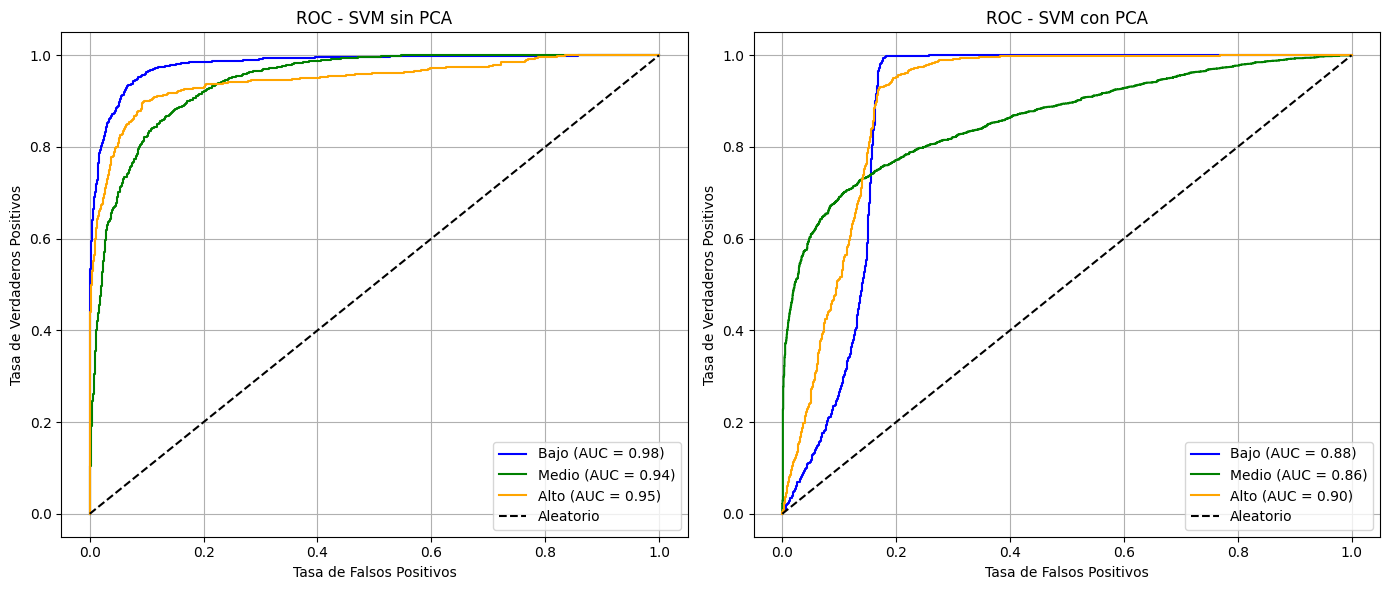

In [139]:
# Graficar lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['blue', 'green', 'orange']

# ROC sin PCA
for i, color in zip(range(len(classes)), colors):
    axes[0].plot(fpr[i], tpr[i], color=color,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Aleatorio')
axes[0].set_title('ROC - SVM sin PCA')
axes[0].set_xlabel('Tasa de Falsos Positivos')
axes[0].set_ylabel('Tasa de Verdaderos Positivos')
axes[0].legend(loc='lower right')
axes[0].grid(True)

# ROC con PCA
for i, color in zip(range(len(classes)), colors):
    axes[1].plot(fpr_PCA[i], tpr_PCA[i], color=color,
                 label=f'{class_names[i]} (AUC = {roc_auc_PCA[i]:.2f})')
axes[1].plot([0, 1], [0, 1], 'k--', label='Aleatorio')
axes[1].set_title('ROC - SVM con PCA')
axes[1].set_xlabel('Tasa de Falsos Positivos')
axes[1].set_ylabel('Tasa de Verdaderos Positivos')
axes[1].legend(loc='lower right')
axes[1].grid(True)

plt.tight_layout()
plt.show()

---

## Conclusiones

---

### Impacto de PCA sobre Modelos SVM

No se observan mejoras significativas en el tiempo de ejecución ni en el rendimiento del modelo al emplear el dataset reducido por medio de PCA.

#### Rendimiento de Clasificación: Sin Cambios Notables

Al revisar los reportes de clasificación, es evidente que **PCA no altera de manera significativa el rendimiento de clasificación** del modelo SVM en términos de **precisión, exhaustividad (recall), puntuación F1 y exactitud (accuracy) general**. Las métricas para ambos conjuntos de datos, "Regular" y "PCA", son prácticamente idénticas:

* **Exactitud (Accuracy):** Ambos modelos alcanzan una exactitud general de 0.87.
  
* **Promedios Macro:**
    * Precisión: 0.86
    * Exhaustividad: 0.83
    * Puntuación F1: 0.84
* **Promedios Ponderados (Weighted):**
    * Precisión: 0.87
    * Exhaustividad: 0.87
    * Puntuación F1: 0.87

Esto sugiere que, para este conjunto de datos y configuración de SVM, la reducción de dimensionalidad realizada por PCA **ha conservado la información esencial** necesaria para una clasificación precisa. La capacidad del modelo para distinguir entre las clases se mantiene consistente, ya sea que procese el conjunto completo de características o las características transformadas por PCA.

#### Poder Predictivo (Área bajo la Curva ROC - AUC):

Aunque las métricas de clasificación permanecen estables, los valores de AUC para la curva ROC muestran una clara divergencia, especialmente para la clase *media*.

#### Eficiencia Computacional

* **Tiempo de Entrenamiento del Modelo Original:** 18.8 s ± 128 ms por ciclo
* **Tiempo de Entrenamiento del Modelo PCA:** 18.4 s ± 62 ms por ciclo

Esto demuestra que la diferencia en el tiempo de entrenamiento para el modelo SVM es despreciable cuando se utilizan datos transformados por PCA en comparación con el conjunto de datos completo.